# 4. Data exploration

We want to figure out what kind of problems we can expect to encounter.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pipelines_2004_selected_file = '../preprocessed_data/pipelines_2004_selected_2019-08-11.feather'
pipelines_2010_selected_file = '../preprocessed_data/pipelines_2010_selected_2019-08-03.feather'

incidents_selected = '../preprocessed_data/incidents_filtered_2019-08-11.feather'

## Read data

In [3]:
pipelines_2004 = pd.read_feather(pipelines_2004_selected_file)
pipelines_2004.sample(3)

,OPERATOR_ID,YEAR,NAME,MILES_TOTAL
242,30909,2008,TRANSMONTAIGNE PRODUCTS SERVICES INC,11.00
2515,31527,2007,GORDON TERMINAL SERVICES,4.94
1852,4906,2004,EXXONMOBIL PIPELINE COMPANY,766.00


In [4]:
pipelines_2010 = pd.read_feather(pipelines_2010_selected_file)
pipelines_2010.sample(3)

,OPERATOR_ID,YEAR,NAME,COMMODITY,MILES
138,26026,2017,"MARKWEST RANGER PIPELINE COMPANY, L.L.C.",HVL,81.49
3103,31178,2010,XTO ENERGY INC,CO2,0.00
2169,32179,2012,EXXONMOBIL BILLINGS REFINERY,Crude Oil,0.00


## 4.1 Check for inconsistency between old (2004-2009) and new (2010-present) reporting

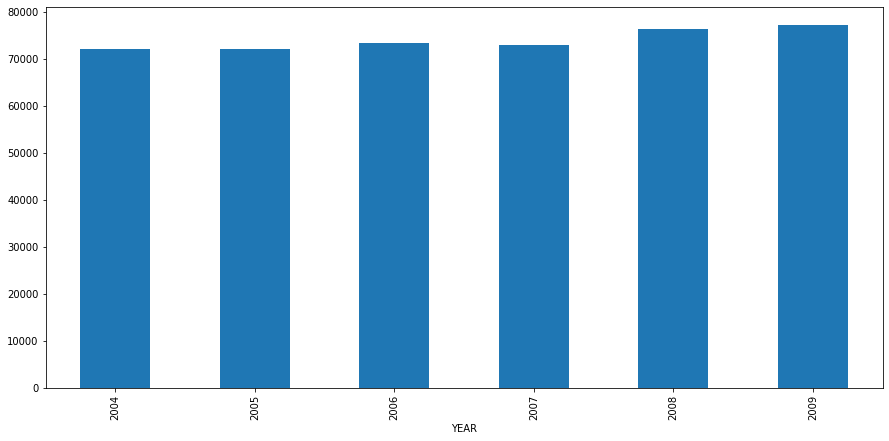

In [5]:
pipelines_2004.groupby('YEAR')['MILES_TOTAL'].sum().plot.bar(figsize=(15, 7))

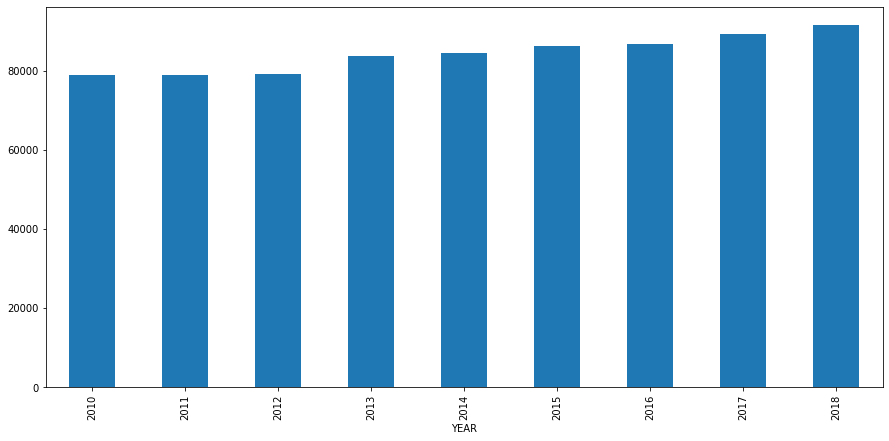

In [6]:
pipelines_2010.groupby('YEAR')['MILES'].sum().plot.bar(figsize=(15, 7))

At least it seems the data reported is the same, albeit grouped differently.

## 4.2 Number of observations in the new data

In [7]:
import rpy2.rinterface

In [8]:
%load_ext rpy2.ipython

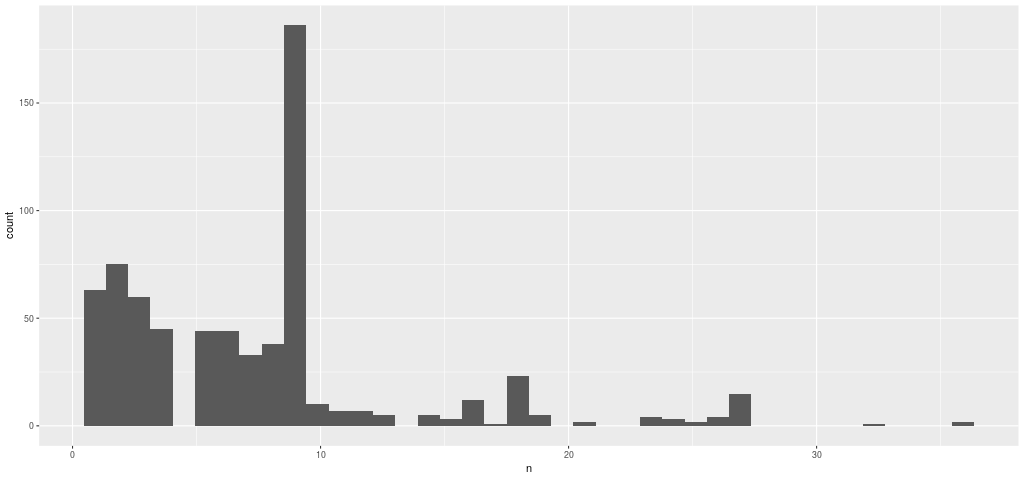

In [9]:
%%R -i pipelines_2010 -w 1024
suppressMessages(library(tidyverse))

pipelines_2010 %>%
    group_by(OPERATOR_ID) %>%
    summarize(n=n()) %>%
    ggplot(aes(x=n)) +
        geom_histogram(bins=40)

## 4.3 Find sources of inconsistency in incidents data

#### Read incidents data

In [10]:
incidents = pd.read_feather(incidents_selected)
incidents.sample(5)

,OPERATOR_ID,LOCAL_DATETIME,NAME,SERIOUS,SIGNIFICANT,LOCATION_LATITUDE,LOCATION_LONGITUDE
1885,1845,2014-12-17 09:40:00,"BUCKEYE PARTNERS, LP",False,False,41.643229,-87.467121
17,31174,2010-01-27 15:30:00,"SHELL PIPELINE CO., L.P.",False,False,29.891600,-93.989700
1445,1845,2013-12-18 13:30:00,"BUCKEYE PARTNERS, LP",False,False,40.519999,-75.531339
1771,300,2014-09-01 07:10:00,"PLAINS PIPELINE, L.P.",False,False,32.081519,-103.180924
3779,31618,2019-05-16 17:20:00,ENTERPRISE PRODUCTS OPERATING LLC,False,True,30.414900,-95.325300


## Incidents data - find source of inconsistency in name vs ID column

Here, we sample the largest observations to see what kind of issues we might expect to see later on.

In [11]:
incidents['NAME'].value_counts().head(10)

ENTERPRISE CRUDE PIPELINE LLC          276
ENTERPRISE PRODUCTS OPERATING LLC      214
SUNOCO PIPELINE L.P.                   211
PLAINS PIPELINE, L.P.                  203
MAGELLAN PIPELINE COMPANY, LP          180
COLONIAL PIPELINE CO                   177
BUCKEYE PARTNERS, LP                   148
PHILLIPS 66 PIPELINE LLC               121
KINDER MORGAN LIQUID TERMINALS, LLC    117
MARATHON PIPE LINE LLC                 111
Name: NAME, dtype: int64

In [12]:
incidents['OPERATOR_ID'].value_counts().head(10)

30829    282
31618    214
18718    211
300      202
22610    180
2552     177
31684    155
1845     148
26041    117
32109    112
Name: OPERATOR_ID, dtype: int64

It is possible that companies changed their name, which led to the discrepancy. But considering how little off the numbers are, it seems far more likely that there are typos/inconsistencies in naming, which occured during data entry.

In [13]:
def find_ranges(df, column):
    for entry in list(df[column].unique()):
        start_date = df[df[column] == entry]['LOCAL_DATETIME'].min()
        end_date = df[df[column] == entry]['LOCAL_DATETIME'].max()
        print(f'''
        Entry:      {entry}
        Start date: {start_date}
        End date :  {end_date}''')

In [14]:
find_ranges(incidents.loc[incidents['OPERATOR_ID'] == 30829], 'NAME')


        Entry:      TEPPCO CRUDE PIPELINE, LLC
        Start date: 2010-03-15 10:00:00
        End date :  2010-08-05 15:00:00

        Entry:      ENTERPRISE CRUDE PIPELINE LLC
        Start date: 2010-10-26 09:30:00
        End date :  2019-06-27 10:15:00


In [15]:
find_ranges(incidents.loc[incidents['NAME'] == 'PLAINS PIPELINE, L.P.'], 'OPERATOR_ID')


        Entry:      300
        Start date: 2010-01-07 13:00:00
        End date :  2019-06-19 07:30:00

        Entry:      26085
        Start date: 2019-01-24 17:23:00
        End date :  2019-01-24 17:23:00


In [16]:
incidents.loc[incidents['OPERATOR_ID'] == 26085].tail()

,OPERATOR_ID,LOCAL_DATETIME,NAME,SERIOUS,SIGNIFICANT,LOCATION_LATITUDE,LOCATION_LONGITUDE
2990,26085,2017-07-06 06:04:00,"PLAINS MARKETING, L.P.",False,True,35.054057,-119.314820
3297,26085,2018-03-19 15:10:00,"PLAINS MARKETING, L.P.",False,False,33.862523,-118.223255
3461,26085,2018-08-29 15:30:00,"PLAINS MARKETING, L.P.",False,False,35.054400,-119.317800
3469,26085,2018-09-08 09:30:00,"PLAINS MARKETING, L.P.",False,False,30.003623,-90.855824
3639,26085,2019-01-24 17:23:00,"PLAINS PIPELINE, L.P.",False,False,32.013470,-102.016347


The two segments were merged? Seems like for this observation, it would be fair to work with the operator id.

In [17]:
find_ranges(incidents.loc[incidents['OPERATOR_ID'] == 31684], 'NAME')


        Entry:      CONOCOPHILLIPS
        Start date: 2010-01-11 14:30:00
        End date :  2012-04-19 16:37:00

        Entry:      PHILLIPS 66 PIPELINE LLC
        Start date: 2012-05-23 07:30:00
        End date :  2019-06-24 04:35:00


Phillips 66 is a spin-off (https://en.wikipedia.org/wiki/ConocoPhillips)

In [18]:
find_ranges(incidents.loc[incidents['OPERATOR_ID'] == 32109], 'NAME')


        Entry:      ONEOK NGL PIPELINE LP
        Start date: 2010-01-01 07:15:00
        End date :  2012-05-01 18:15:00

        Entry:      ONEOK NGL PIPELINE, LLC
        Start date: 2012-08-19 22:30:00
        End date :  2019-06-23 06:58:00


Changed legal status.